In [1]:
import matplotlib.pyplot as plt
# from matplotlib import interactive
import numpy as np
import os
import subprocess
import time
from  datetime import datetime
import math
from joint_can import *
%matplotlib widget

In [2]:
def save_data(data: np.array, file_path: str, note: str, serial_nr: str, torque: float, temps: list) -> None:
    with open(file_path+'/'+serial_nr+'/'+serial_nr+time.strftime('_%y_%m_%d_%H_%M')+'.txt','w') as file:
        file.write("serial number: " + serial_nr+'\n')
        file.write("torque: "+str(torque)+'\n')
        
        file.write("start_temp: "+str(temps[1][0]) +" ("+str(temps[0][0])+")\n")
        file.write("finish_temp: "+str(temps[1][1]) +" ("+str(temps[0][1])+")\n")
        
        file.write("note: " + note+'\n')
        for line in data:
            file.write(f'{line[0]:.6f} {line[1]:.6f}\n')

In [3]:
# Ustawienie adresu CAN na "nr_id"

def initialize_joint(bus, mode: int, nr_id):
    send_msg(0x1A0 + nr_id, None, bus) # reset jointa
    time.sleep(1)
    
    send_msg(0x1b0 + nr_id, [0,0,0,0,0,0], bus) 
    time.sleep(0.1)
    send_msg(0x140 + nr_id, None, bus) # zapis konfiguracji FLASH
    time.sleep(0.1)
    send_msg(0x1a0 + nr_id, None, bus) # WTF 2 reset jointa
    time.sleep(1)
    
    if (send_msg(0x1F0 + nr_id, [mode, 2], bus).data[0] == 1): # konfiguracja jointa
        send_msg(0x110 + nr_id, [2], bus)
        time.sleep(1)
        send_msg(0x110 + nr_id, [3], bus).data[0]
        time.sleep(5)
        return True
    else:
        return False
      


Parametry diagnostyki:

In [4]:
bus = can.interface.Bus(bustype='socketcan', channel='can0', bitrate=1000000, data_bitrate=5000000, fd=True)
nr_id = get_can_id(bus) #numer id jaki chcemy nadac do jointa 

serial="JANUSZ_8_RI80_20901020062_new" #musi byc min jedna litera w numerze
note="Joint 1, Janusz 8" #póki co musi być cokolwiek
path = "/home/pi/mech_diagnostics/diagnostic_data"

In [5]:
diag_samples = 1500 #liczba próbek pozycji (rozdzielczość)
# run_duration = 2 #czas trwania diagnostyki w minutach

Ścieżka pliku do wyrysowania:

(Diagnostyka zostanie uruchomiona jedynie gdy target_file="" . Po podaniu nazw plików target_file i ref_file zostanie tylko wyrysowany wykres obu zestawóww danych (diagnostyka nie będzie uruchomiona )

In [6]:
target_file=""

Ścieżka pliku referencyjnego:

In [7]:
ref_file=""

# Ustawienie temperatury

In [8]:
# os.popen('/home/pi/mech_diagnostics/can_down.sh')
# time.sleep(1)
# os.popen('/home/pi/mech_diagnostics/can_up.sh')
# time.sleep(2)

In [25]:
# initialize_joint(bus, 2, nr_id) # mode 1 - torque, 2 - speed

True

parametry temperatury

In [10]:
# # parametry rozgrzewki jointa
# min_temp = 30
# max_temp = 31
# speed = 2. #predkosc na ktorej joint jest rozgrzewany

In [11]:
# c_speed=0.
# j_data=set_speed(c_speed,bus, nr_id)
# data_t=get_temp(bus, nr_id)

# while(data_t.bearing_temp<min_temp or data_t.bearing_temp>max_temp):
#     if data_t.bearing_temp<min_temp:
#         c_speed=speed
#     else:
#         c_speed=0.
#     j_data=set_speed(c_speed,bus, nr_id)
#     data_t=get_temp(bus, nr_id)
#     print(f'\r tq: {j_data.torque:.3f}\tm_temp: {data_t.motor_temp:.3f}\tb_temp: {data_t.bearing_temp:.3f}', end='')
#     time.sleep(1)
# send_msg(0x1A0 + nr_id, None, bus)

 tq: 39.871	m_temp: 36.000	b_temp: 30.000

# Diagnostyka

In [12]:
try: 
    os.mkdir(path+'/'+serial) 
except OSError as error: 
    pass

In [15]:
initialize_joint(bus, 1, nr_id) # mode 1 - torque, 2 - speed

True

In [13]:
# if not len(target_file):
#     while not initialize_joint(bus,1,nr_id):
#         print("Joint initialization in progress")

can.Message(timestamp=1712239840.4246237, arbitration_id=0x3f1, is_extended_id=False, channel='can0', dlc=1, data=[0x1], is_fd=True, bitrate_switch=True, error_state_indicator=False)

In [16]:
const_torque = 12. #zadawany moment obrotowy w Nm (konieczna kropka na końcu jeżeli jest to liczba całkowita) 16 dla J25, 8 dla J20
ilosc_obrotow_silnika = 121.*10

print("Running diagnostics...")
position_bins=np.linspace(0, 2*math.pi, diag_samples)
start_time=time.time()
data=[]

motor_temp=[0,0]
bearing_temp=[0,0]

current_reading = set_torque(const_torque,bus,nr_id)
current_reading_temp = get_temp(bus, nr_id)
motor_temp[0] = current_reading_temp.motor_temp
bearing_temp[0] = current_reading_temp.bearing_temp
time.sleep(0.01)
current_reading=set_torque(const_torque,bus,nr_id)
time.sleep(5)
current_reading=set_torque(const_torque,bus,nr_id)
starting_position = current_reading.position + math.pi
i = 0
start = datetime.now()
previous_position = -10

zakres_ruchu = ilosc_obrotow_silnika * 2 * math.pi / 121

while True:
    start_time = datetime.now()
    i += 1
    current_reading=set_torque(const_torque,bus,nr_id) # Ramka 0
    current_reading_temp=get_temp(bus,nr_id) # ramka 8
    # ----
    current_position = (current_reading.position - starting_position - math.pi) % (math.pi * 2)
    # current_position = current_reading.position
    current_speed = current_reading.speed
    data.append([current_position, current_speed])

    # ----------
    end_time = datetime.now()
    period = (end_time - start_time).total_seconds()
    # print(f"{current_position} {starting_position} {current_speed}")
    time.sleep(max(0, 0.010 - period))   
    # if i > 10000 or current_position  < previous_position: break
    # if current_position < previous_position: break
    if i > 5000 or current_position > zakres_ruchu: break
    previous_position = current_position
    
    # print(f'\r Time left: {(math.floor(run_duration-cur_time/60))} min {int((run_duration*60-cur_time)%60)} sec\t\t', end='')
    # if np.sign(current_reading.torque) == np.sign(const_torque):
    #     motor_temp[1] = current_reading_temp.motor_temp
    #     bearing_temp[1] = current_reading_temp.bearing_temp
    #     data.append([current_reading.position + math.pi, current_reading.speed])
    # else:
    #     if cur_time>30:
    #         print("Speed/Torque sign error, aborting.")
    #         break
    
        
stop = datetime.now()
print(f"Wykonano w {stop - start}s. Rozmiar listy {len(data)}")
set_torque(0,bus, nr_id)

Running diagnostics...
Wykonano w 0:00:50.713446s. Rozmiar listy 5001


In [15]:
data = np.array(data)
position_bin_num = np.digitize(data[:,0],position_bins)
binarized_avg_data = np.array([position_bins,np.zeros(diag_samples)]).T
for i in range(diag_samples):
    binarized_avg_data[i,1]=np.mean(data[position_bin_num==i,1])

/home/pi/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pi/.local/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [16]:
save_data(binarized_avg_data, path, note, serial, const_torque, [motor_temp, bearing_temp])

# Wykresy

In [17]:
plt.rcParams['figure.figsize'] = [12, 8]

Zakres dopuszczalnej prędkości

In [18]:
# definicja zielonej sekcji na wykresie
ref_v_min=0.25
ref_v_max=0.45
avg_samples = 5  #ilość próbek do uśredniania obliczeń jittera

In [19]:
flist=os.listdir(path+'/'+serial)
flist.sort()
flist.reverse()
ref_data=[]
            
            
for fname in flist:
    if '.txt' not in fname:
        flist.remove(fname)

if len(ref_file):
    rfname=ref_file+'.txt'
    data_points = []
    with open(path+'/'+serial+'/'+rfname) as file:
        ref_data = (list(file))

        if "serial number: " in ref_data[0]:
            rf_serial = ref_data[0].strip()
            ref_data.remove(ref_data[0])
        else:
            rf_serial = ''

        if "torque: " in ref_data[0]:
            rf_tq = ref_data[0].strip()
            ref_data.remove(ref_data[0])
        else:
            rf_tq = ''

        if "start_temp: " in ref_data[0]:
            rf_temp1 = ref_data[0].strip()
            ref_data.remove(ref_data[0])
        else:
            rf_temp1 = ''

        if "finish_temp: " in ref_data[0]:
            rf_temp2 = ref_data[0].strip()
            ref_data.remove(ref_data[0])
        else:
            rf_temp2 = ''

        if "note: " in ref_data[0]:
            rf_note = ref_data[0].strip()
            ref_data.remove(ref_data[0])
        else:
            rf_note = ''

        ref_data = [point.split() for point in ref_data]

        ref_data = np.array(ref_data, dtype=float)
        


Wykresy prędkości przy stałym momencie:

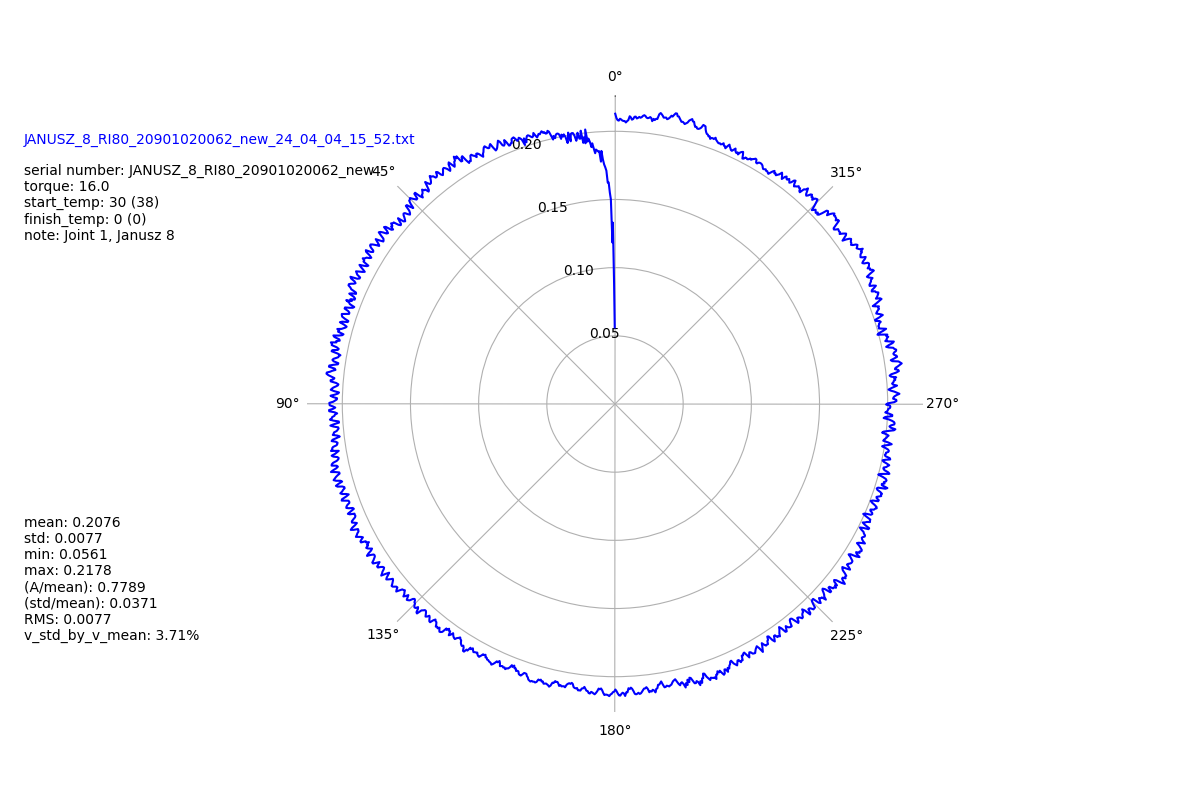

In [20]:
if target_file[-4:]!='.txt':
    target_file=target_file+".txt"

for fname in flist:
    # if len(target_file):
    #     if target_file != fname:
    #         continue
    if serial in fname and '.txt' in fname or fname == target_file:
        data_points = []
        with open(path+'/'+serial+'/'+fname) as file:
            data_points+=(list(file))
                   
        if "serial number: " in data_points[0]:
            r_serial=data_points[0].strip()
            data_points.remove(data_points[0])
        else:
            r_serial=''
            
        if "torque: " in data_points[0]:
            r_tq=data_points[0].strip()
            data_points.remove(data_points[0])
        else:
            r_tq=''
            
        if "start_temp: " in data_points[0]:
            r_temp1=data_points[0].strip()
            data_points.remove(data_points[0])
        else:
            r_temp1=''
            
        if "finish_temp: " in data_points[0]:
            r_temp2=data_points[0].strip()
            data_points.remove(data_points[0])
        else:
            r_temp2=''
        
        if "note: " in data_points[0]:
            r_note=data_points[0].strip()
            data_points.remove(data_points[0])
        else:
            r_note=''
            
        data_points=[point.split() for point in data_points]
        data_points=np.array(data_points, dtype=float)
        data_points = data_points[~np.isnan(data_points[:,1])]
        # print(data_points[1])

        f, a = plt.subplots(subplot_kw={'projection': 'polar'})
        f.canvas.manager.set_window_title(fname)
        
        avg_samples = 10 # Przykładowa wartość dla ilości próbek do średniej ruchomej
        # fname, r_serial, r_tq, r_temp1, r_temp2, r_note = 'Przykład', 'Serial', 'Tq', 'Temp1', 'Temp2', 'Notatka'

        v_min = data_points[:,1].min() # Min
        v_max = data_points[:,1].max() # Max
        v_mean = np.nanmean(data_points[:,1]) # Średnia
        v_std = np.nanstd(data_points[:,1]) # Odchylenie standardowe
        v_A = (v_max - v_min) # Różnica między maksymalną a minimalną
        v_std_by_v_mean = (v_std / v_mean) * 100 # Różnica między maksymalną a minimalną

        # Obliczanie wartości skutecznej
        v_rms = np.sqrt(np.nanmean((data_points[:,1] - v_mean)**2))

        v_moving_avg = np.convolve(data_points[:,1], np.ones(avg_samples), 'same') / avg_samples
        boundary = int(np.ceil(avg_samples / 2))
        v_moving_avg_deviation_mean = np.nanmedian(abs(data_points[:,1] - v_moving_avg)[boundary:-boundary])

        plt.figtext(0.02, 0.82, str(fname), color = 'blue')
        plt.figtext(0.02, 0.7, r_serial+'\n'+r_tq+'\n'+r_temp1+'\n'+r_temp2+'\n'+r_note)
        plt.figtext(0.02, 0.2, 'mean: '+ str(round(v_mean,4))+'\nstd: '+str(round(v_std,4))+'\nmin: '+ str(round(v_min,4))+'\nmax: '+ str(round(v_max,4))+'\n(A/mean): ' + str(round(v_A/v_mean,4)) + '\n(std/mean): ' + str(round(v_std/v_mean,4)) + '\nRMS: ' + str(round(v_rms,4)) + '\nv_std_by_v_mean: ' + str(round(v_std_by_v_mean,2)) + '%')

        
#         if len(ref_data):
#             a.set_ylim(0,max(0.6,data_points[:,1].max(),ref_data[:,1].max())) #zakres predkosci wykresu
#         else:
#             a.set_ylim(0,max(0.6,data_points[:,1].max())) #zakres predkosci wykresu
                
        a.set_theta_offset(1.57)
        
        a.plot(data_points[:, 0], data_points[:, 1],color='blue')
        
#         a.fill_between(data_points[:,0],ref_v_min,ref_v_max,alpha=0.2,linewidth=0,color='green')
        
#         v_min = data_points[:,1].min() #min
#         v_max = data_points[:,1].max() #max
#         v_mean = np.nanmean(data_points[:,1]) #wartosc srodkowa
#         v_std = np.nanstd(data_points[:,1]) #odchylenie standardowe
#         v_A = (v_max-v_min)
        
#         v_moving_avg = np.convolve(data_points[:,1],np.ones(avg_samples),'same')/avg_samples
#         boundary=int(np.ceil(avg_samples/2))
#         v_moving_avg_deviation_mean = np.nanmedian(abs(data_points[:,1]-v_moving_avg)[boundary:-boundary])
        
#         # f.suptitle("Joint "+str(fname))
#         # a.set_title(str(r_tq)+' '+str(r_temp1)+' '+str(r_temp2))
#         plt.figtext(0.02,0.82,str(fname),color = 'blue')
#         plt.figtext(0.02,0.7,r_serial+'\n'+r_tq+'\n'+r_temp1+'\n'+r_temp2+'\n'+r_note)
#         plt.figtext(0.02,0.2,'mean: '+ str(round(v_mean,4))+'\nstd: '+str(round(v_std,4))+'\nmin: '+ str(round(v_min,4))+'\nmax: '+ str(round(v_max,4))+'\n(A/mean): ' + str(round(v_A/v_mean,4)) + '\n(std/mean): ' + str(round(v_std/v_mean,4))+
#                    '\nmaćkowe: ' + str(round(v_moving_avg_deviation_mean,9)))
        
#         if len(ref_data):
#             a.plot(ref_data[:, 0], ref_data[:, 1],alpha=0.8,color='green')
#             plt.figtext(0.78,0.82,str(rfname),color = 'green')
#             plt.figtext(0.78,0.7,rf_serial+'\n'+rf_tq+'\n'+rf_temp1+'\n'+rf_temp2+'\n'+rf_note)
#             plt.figtext(0.78,0.2,'mean: '+ str(round(np.nanmean(ref_data[:,1]),4))+'\nstd: '+str(round(np.nanstd(ref_data[:,1]),4))+'\nmin: '+ str(round(ref_data[:,1].min(),4))+'\nmax: '+ str(round(ref_data[:,1].max(),4)))
        
        try:
            if len(target_file) and len(ref_data):
                plt.savefig( path+'/'+serial+'/'+fname[:-4] + "_comp.png", dpi=150)
            else:
                plt.savefig( path+'/'+serial+'/'+fname[:-4] + ".png", dpi=150)   
        except PermissionError:
                print(f"Brak pozwolenia na nadpisanie pliku {fname}")

In [21]:
# send_msg(0x1A0 + nr_id, None, bus)
# time.sleep(1)
# send_msg(0x1F0 + nr_id, [2,2], bus)
# send_msg(0x110 + nr_id, [2], bus)
# time.sleep(1)
# send_msg(0x110 + nr_id, [3], bus)
# time.sleep(2)


# data=set_speed(0,bus,nr_id)
# sgn=(int(data.position>0) - int(data.position<0))

# data=set_speed(sgn*0.1,bus,nr_id)
# print(data.position)
# while(abs(data.position)>0.01):
#     if (abs(data.position)>0.2):
#         data=set_speed(sgn*-0.25,bus,nr_id)
#     else:
#         data=set_speed(sgn*-0.05,bus,nr_id)
#     time.sleep(0.1)

# send_msg(0x110 + nr_id, [2], bus)
# print(data.position)

# 